# 1. Importing libraries, helper functions and data paths

### 1.1 Importing libraries

In [1]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path

In [3]:
from torchinfo import summary
from typing import List, Tuple, Dict
from tqdm.auto import tqdm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
print(device)

cuda


### 1.2 Importing helper functions

In [6]:
from going_modular.data_setup import create_dataloaders
from going_modular.engine import train_step

In [7]:
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device = torch.device)->Tuple[float,float]:

    #putting model on evaluation mode
    model.eval()

    #Setup test loss and test accuracy values
    val_loss, val_acc = 0,0

    #turning on inference mode (we don't need the gradient engine activated)
    with torch.inference_mode():
        #Loop through Dataloader batches
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)

            #1. Forward pass
            val_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(val_pred_logits,y)
            val_loss += loss.item()

            #Calculate the accuracy
            val_pred_labels = torch.argmax(val_pred_logits, axis = 1)
            val_acc += (val_pred_labels==y).sum().item()/len(val_pred_labels)

    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)

    return val_loss, val_acc

In [8]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str = None):
    '''
    Creates a torch.utils.tensorboard.writer.SummaryWriter() instance trancking to a specific directory
    '''
    from datetime import datetime
    import os

    #get timestamp of current date in reverse order
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join('Publication_Phase_2_logs',timestamp,experiment_name,model_name,extra)
    else:
        log_dir = os.path.join('Publication_Phase_2_logs',timestamp,experiment_name,model_name)

    print(f"Created SummaryWriter saving to {log_dir}")
    return SummaryWriter(log_dir)

In [9]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

def train(model: torch.nn.Module,
         train_dataloader,
         val_dataloader,
         optimizer,
         writer: torch.utils.tensorboard.writer.SummaryWriter,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
         epochs: int = 5,
         device = torch.device,
         lr_scheduler = None)->Dict[str,List]:

    #Create dictionary of lists
    results = {"train_loss": [],
              "train_acc": [],
              "val_loss": [],
              "val_acc": []}

    #looping through training and test steps
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                          dataloader = train_dataloader,
                                          loss_fn = loss_fn,
                                          optimizer = optimizer,
                                          device = device)

        val_loss, val_acc = val_step(model = model,
                                       dataloader = val_dataloader,
                                       loss_fn = loss_fn,
                                       device = device)
        current_lr = optimizer.param_groups[0]['lr']

        #print out what's happening
        print(f'''Epoch: {epoch+1}| Train loss: {train_loss:.4f} and Train acuuracry: {train_acc:.4f} |
                  Validation loss: {val_loss:.4f} and Validation accuracy: {val_acc:.4f}|
                  LR: {current_lr}''')


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        ###Alteration (NEW): Experiment Tracking###
        if writer:
            writer.add_scalars(main_tag = "Loss",
                              tag_scalar_dict = {"train_loss":train_loss,
                                                "val_loss":val_loss},
                              global_step=epoch)
            writer.add_scalars(main_tag = "Accuracy",
                             tag_scalar_dict = {"train_acc":train_acc,
                                               "val_acc":val_acc},
                             global_step = epoch)
            if epoch == 0:
                writer.add_graph(model = model,
                                input_to_model = torch.randn(32,3,224,224).to(device))
        else:
            pass

        #stepping the lr_scheduler
        if lr_scheduler is not None:
            lr_scheduler.step()
    #Close the writer
    writer.close()

    return results

In [10]:
def save_model(model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler = None,
               epoch: int = 0,
               initial_training_completed: bool = False,
               target_dir: str = "models",
               model_name: str = "model_checkpoint.pth"):
    """
    Saves a dictionary containing model, optimizer, scheduler states, and training metadata.

    Args:
        model: The PyTorch model to save.
        optimizer: The optimizer used during training.
        scheduler: The learning rate scheduler used during training (optional).
        epoch: The current epoch number.
        initial_training_completed: Flag indicating if initial training phase is complete.
        target_dir: Directory where the checkpoint will be saved.
        model_name: Filename for the checkpoint, should end with '.pth' or '.pt'.

    Example usage:
        save_model(model=model_0,
                   optimizer=optimizer,
                   scheduler=scheduler,
                   epoch=15,
                   initial_training_completed=True,
                   target_dir="models",
                   model_name="efficientnet_b0_initial_training.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), \
        "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'initial_training_completed': initial_training_completed,
    }

    print(f"[INFO] Saving checkpoint to: {model_save_path}")
    torch.save(obj=checkpoint, f=model_save_path)

In [11]:
import matplotlib.pyplot as plt
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]], title=None):
    '''
    Plots training curves of a results dictionary with unique markers and grid lines.
    '''
    # Get the loss and accuracy values
    loss = results["train_loss"]
    test_loss = results["val_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["val_acc"] 
    
    # Number of epochs
    epochs = range(len(loss))
    
    # Setup plot
    plt.figure(figsize=(15, 7))
    
    # Plot the loss with unique markers
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss', marker='o', linestyle='-')
    plt.plot(epochs, test_loss, label='Val Loss', marker='D', linestyle='--')
    plt.title('Loss' if title is None else f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    # Plot the accuracy with unique markers
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Train Accuracy", marker='*', linestyle='-')
    plt.plot(epochs, test_accuracy, label="Val Accuracy", marker='^', linestyle='--')
    plt.title("Accuracy" if title is None else f'{title} - Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from typing import List
import numpy as np

def plot_confusion_matrix(model: torch.nn.Module,
                          dataloader: torch.utils.data.DataLoader,
                          class_names: List[str],
                          device=torch.device("cpu")):
    """
    Computes and plots the confusion matrix for a given model and dataloader.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for the test dataset.
        class_names: List of class names in the same order as in ImageFolder.
        device: Device on which computation should happen (default: "cpu").
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_multiclass_pr_curve(model, dataloader, class_names, device, title = None):

    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Softmax for multiclass
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)

    plt.figure()
    for i, class_name in enumerate(class_names):
        # One-vs-rest binarization for true labels
        binary_true = (y_true == i).astype(int)
        precision, recall, _ = precision_recall_curve(binary_true, y_score[:, i])
        plt.plot(recall, precision, label=f'PR Curve: {class_name}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plot_title = title if title is not None else 'Multiclass Precision-Recall Curve'
    plt.title(plot_title)
    plt.legend()
    plt.show()

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc


def plot_multiclass_roc_curve(model, dataloader, class_names, device, title=None):
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Softmax for multiclass
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)
    
    plt.figure(figsize=(8, 6))
    
    for i, class_name in enumerate(class_names):
        binary_true = (y_true == i).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7, label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    
    plot_title = title if title is not None else 'Multiclass ROC Curve'
    plt.title(plot_title, fontsize=14, fontweight="bold")
    
    # Position legend to avoid clutter
    plt.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### 1.3 Getting the datapaths and converting them to dataloaders

In [15]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()

In [16]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

* Original Data

In [17]:
root_dir = Path('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split')

train_dir = root_dir/'Train'
val_dir = root_dir/'Validation'
test_dir = root_dir/'Test'

train_dataloader,  val_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                                    val_dir=val_dir,
                                                                                    test_dir=test_dir,
                                                                                    batch_size=32,
                                                                                    transform=effnetb2_transforms)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2be08fc3df0>,
 <torch.utils.data.dataloader.DataLoader at 0x2be08fc3b50>)

In [18]:
print(class_names)

num_classes = len(class_names)
print(num_classes)

['Burn Through', 'Lack of Penetration', 'Porosity', 'Undercut']
4


* Augmented Data

In [19]:
train_dir_aug = Path('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Roboflow Split/Train')

train_ds_aug = ImageFolder(root=train_dir_aug,
                          transform=effnetb2_transforms)

train_dataloader_aug = DataLoader(dataset=train_ds_aug,
                                 batch_size=32,
                                 shuffle=True)

train_dataloader_aug

# 2. EfficientNetB2 Workflow

### 2.1 Base EfficientNetB2

In [20]:
effnetb2_model = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

summary(effnetb2_model,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [21]:
effnetb2_model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [22]:
for param in effnetb2_model.features.parameters():
    param.requires_grad = False

effnetb2_model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
).to(device)

for param in effnetb2_model.classifier.parameters():
    param.requires_grad = True

summary(effnetb2_model,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Training

In [23]:
from timeit import default_timer as timer

In [24]:
#setting up random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#setting up a loss_fn, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb2_model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                           step_size=10,
                                           gamma=0.1)

n_epochs = 15

#start the time count
start_time = timer()

results = train(model=effnetb2_model,
               train_dataloader=train_dataloader_aug,
               val_dataloader=val_dataloader,
               optimizer=optimizer,
               loss_fn=criterion,
               lr_scheduler=scheduler,
               epochs=n_epochs,
               device=device,
               writer=create_writer(experiment_name='Augmented_Data',
                                   model_name='EffnetB2',
                                   extra=f'{n_epochs}_epochs')
               )
#stop the timer
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')
print('\n')

save_filepath = 'EfficientNetB2_Augmented_data_15_epoch.pth'
save_model(model=effnetb2_model,
          optimizer=optimizer,
          scheduler=scheduler,
          epoch=n_epochs,
          target_dir='Publication_Phase_2_models',
          model_name=save_filepath)

print('model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-02\Augmented_Data\EffnetB2\15_epochs


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.8864 and Train acuuracry: 0.7121 |
                  Validation loss: 0.7219 and Validation accuracy: 0.7833|
                  LR: 0.001
Epoch: 2| Train loss: 0.5622 and Train acuuracry: 0.8315 |
                  Validation loss: 0.6178 and Validation accuracy: 0.7611|
                  LR: 0.001
Epoch: 3| Train loss: 0.4594 and Train acuuracry: 0.8609 |
                  Validation loss: 0.5599 and Validation accuracy: 0.7646|
                  LR: 0.001
Epoch: 4| Train loss: 0.4107 and Train acuuracry: 0.8683 |
                  Validation loss: 0.5443 and Validation accuracy: 0.7771|
                  LR: 0.001
Epoch: 5| Train loss: 0.3806 and Train acuuracry: 0.8787 |
                  Validation loss: 0.5233 and Validation accuracy: 0.7896|
                  LR: 0.001
Epoch: 6| Train loss: 0.3578 and Train acuuracry: 0.8824 |
                  Validation loss: 0.5088 and Validation accuracy: 0.7833|
                  LR: 0.001
Epoch: 7| Train loss: 0.3520

### getting the loss curves

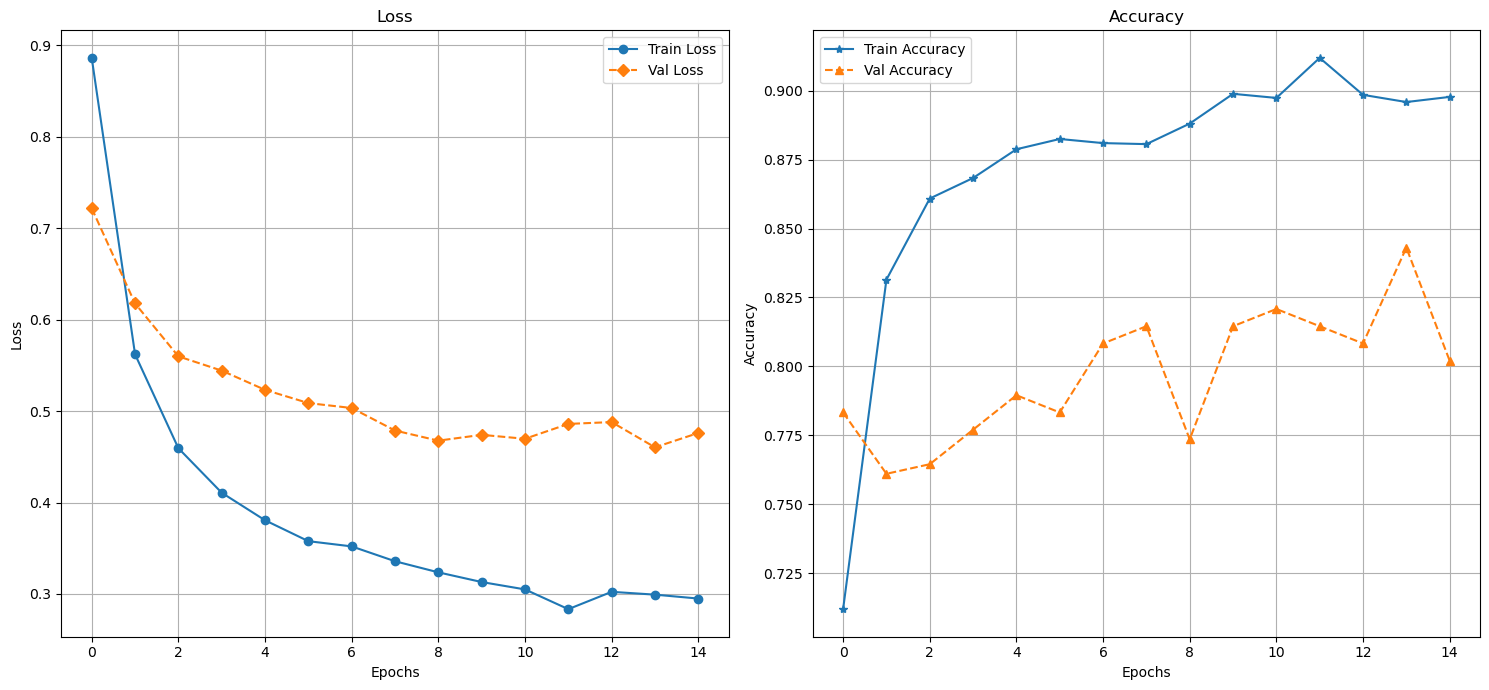

In [25]:
plot_loss_curves(results=results)

### the confusion matrix

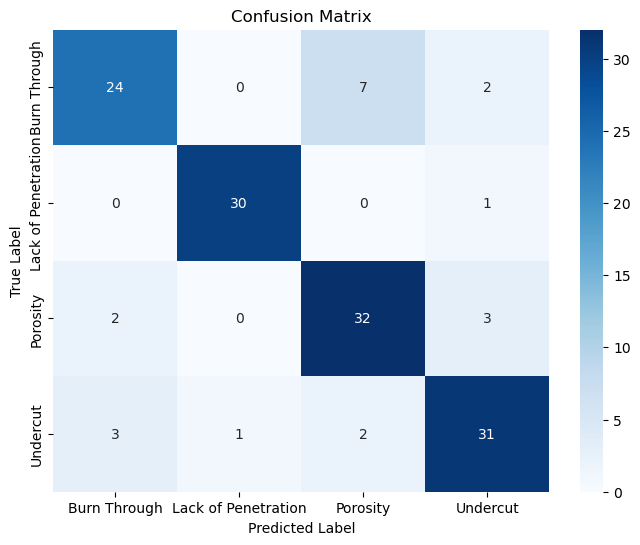

In [26]:
plot_confusion_matrix(model=effnetb2_model,
                     dataloader=test_dataloader,
                     class_names=class_names,
                     device=device)

### 2.2 Fine Tuning EfficientNetB2

In [27]:
from pathlib import Path
checkpoint_path = Path('C:/Users/Sadat Iqbal/Desktop/Python Works/Torch_CUDA/Publication_Phase_2_models/EfficientNetB2_Augmented_data_15_epoch.pth')
checkpoint = torch.load(checkpoint_path,
                       map_location=device)

C:\Users\Sadat Iqbal\AppData\Local\Temp\ipykernel_3996\3548680426.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path,


In [28]:
effnetb2_finetune = torchvision.models.efficientnet_b2(weights=None).to(device)
effnetb2_finetune.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
).to(device)

#loading the model weights
effnetb2_finetune.load_state_dict(checkpoint['model_state_dict'])

#freezing the feature extractor layers first
for name, param in effnetb2_finetune.features.named_parameters():
    param.requires_grad = False

for name, param in list(effnetb2_finetune.features.named_parameters())[-10:]:
    param.requires_grad = True

In [29]:
summary(effnetb2_finetune,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32

### Training

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#setting up a loss_fn and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, effnetb2_finetune.parameters()),
    lr = 1e-4
)

fine_tune_epochs = 5

#starting the timer
start_time = timer()

finetune_results = train(model=effnetb2_finetune,
                        train_dataloader=train_dataloader_aug,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=criterion,
                        epochs=fine_tune_epochs,
                        device=device,
                        writer = create_writer(experiment_name='Augmented_Data',
                                              model_name='EffnetB2',
                                              extra=f'finetuned_for_{fine_tune_epochs}_epochs')
                        )

end_time = timer()
print(f"Total time for fine-tuning: {end_time - start_time:.3f} seconds")

save_filepath = 'EfficienNetB2_Augmented_data_finetuned_for_5_epochs.pth'
save_model(model=effnetb2_finetune,
          optimizer=optimizer,
          epoch=fine_tune_epochs,
          initial_training_completed=True,
          target_dir='Publication_Phase_2_models',
          model_name=save_filepath)
print('Fine-tuned model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-02\Augmented_Data\EffnetB2\finetuned_for_5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.2662 and Train acuuracry: 0.9152 |
                  Validation loss: 0.4071 and Validation accuracy: 0.8458|
                  LR: 0.0001
Epoch: 2| Train loss: 0.2253 and Train acuuracry: 0.9249 |
                  Validation loss: 0.3613 and Validation accuracy: 0.8458|
                  LR: 0.0001
Epoch: 3| Train loss: 0.1767 and Train acuuracry: 0.9457 |
                  Validation loss: 0.3433 and Validation accuracy: 0.8583|
                  LR: 0.0001
Epoch: 4| Train loss: 0.1397 and Train acuuracry: 0.9602 |
                  Validation loss: 0.3415 and Validation accuracy: 0.8521|
                  LR: 0.0001
Epoch: 5| Train loss: 0.1272 and Train acuuracry: 0.9628 |
                  Validation loss: 0.3343 and Validation accuracy: 0.8521|
                  LR: 0.0001
Total time for fine-tuning: 194.397 seconds
[INFO] Saving checkpoint to: Publication_Phase_2_models\EfficienNetB2_Augmented_data_finetuned_for_5_epochs.pth
Fine-tuned model saved to des

### the loss curves

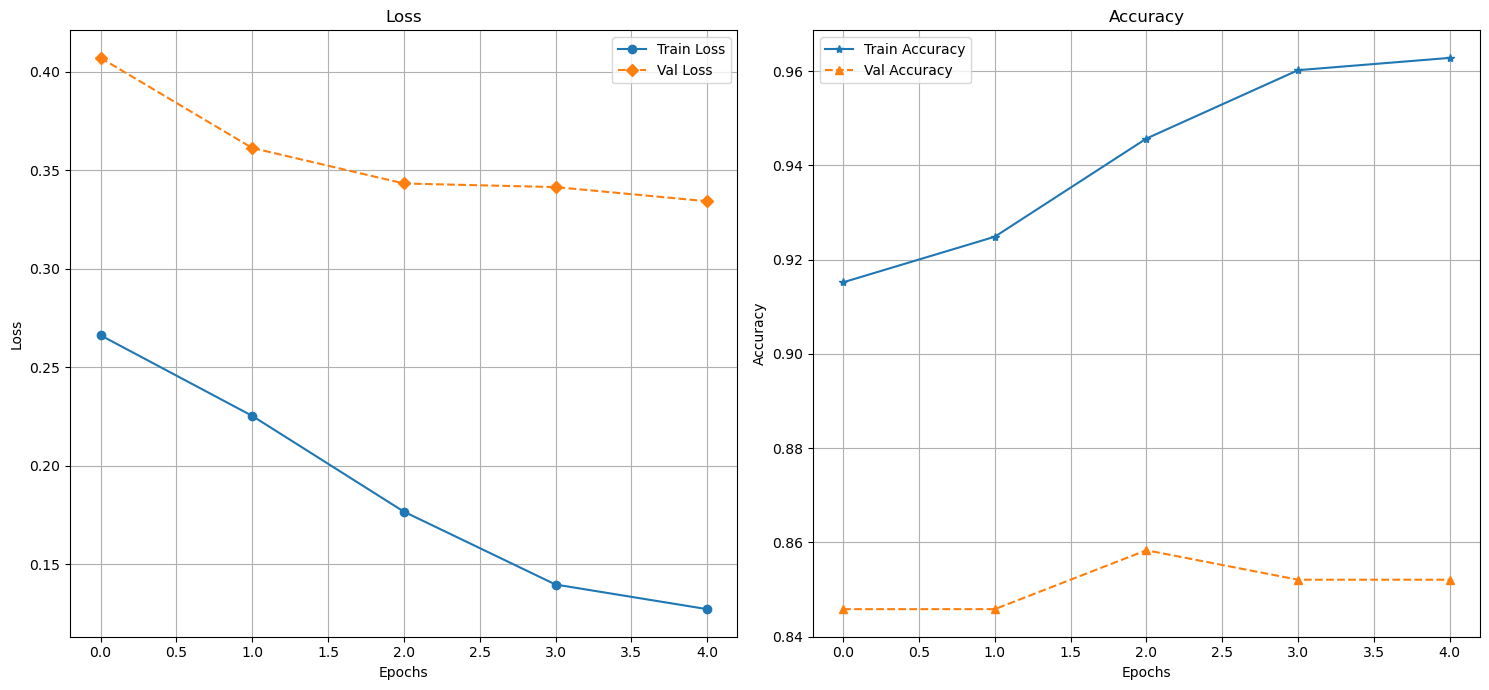

In [31]:
plot_loss_curves(results=finetune_results)

### the confuion matrix

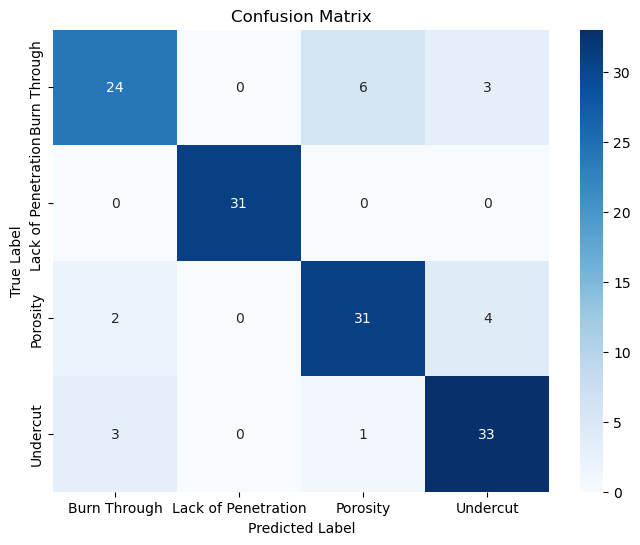

In [32]:
plot_confusion_matrix(model=effnetb2_finetune,
                     dataloader=test_dataloader,
                     class_names=class_names,
                     device=device)

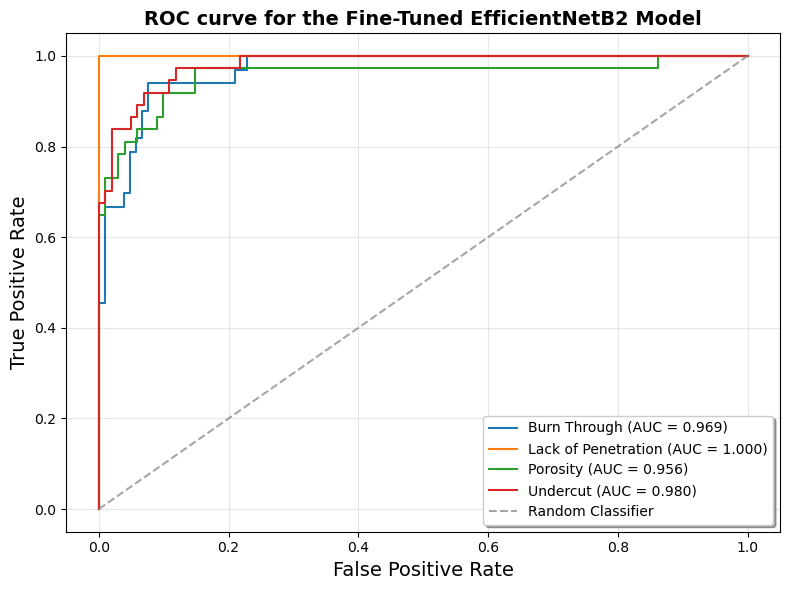

In [52]:
plot_multiclass_roc_curve(model=effnetb2_finetune,
                         dataloader=test_dataloader,
                         class_names=class_names,
                         device = device,
                         title = "ROC curve for the Fine-Tuned EfficientNetB2 Model")

# 3. Effect of SENet Attention Module

In [33]:
from AttentionModules.SENet import SEModule

In [34]:
class effnetb2_with_senet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
        self.model = torchvision.models.efficientnet_b2(weights=self.weights)
        self.feature_extractor = self.model.features
        self.senet = SEModule(channels=1408)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(in_features=1408, out_features=num_classes)
        )

    def forward(self,x):
        x = self.feature_extractor(x)
        x = self.senet(x)
        x = self.pool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)

        return x

In [35]:
effnetb2_se = effnetb2_with_senet(num_classes=num_classes)
summary(effnetb2_se,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
effnetb2_with_senet (effnetb2_with_senet)                    [32, 3, 224, 224]    [32, 4]              1,409,000            True
├─Sequential (feature_extractor)                             [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [36]:
for param in effnetb2_se.feature_extractor.parameters():
    param.requires_grad = False

for param in effnetb2_se.classifier.parameters():
    param.requires_grad = True

summary(effnetb2_se,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
effnetb2_with_senet (effnetb2_with_senet)                    [32, 3, 224, 224]    [32, 4]              1,409,000            Partial
├─Sequential (feature_extractor)                             [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Training

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb2_se.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                            step_size=10,
                                            gamma=0.1)

n_epochs = 15

#starting the timer
start_time = timer()

results_se = train(model=effnetb2_se,
                  train_dataloader=train_dataloader_aug,
                  val_dataloader=val_dataloader,
                  loss_fn=criterion,
                  optimizer=optimizer,
                  lr_scheduler=scheduler,
                  epochs=n_epochs,
                  device=device,
                  writer=create_writer(experiment_name='Augmented_Data',
                                      model_name='EffinetB2_with_SENet',
                                      extra=f'{n_epochs}_epochs')
                  )
end_time = timer()
print(f'Total training time with SENet:{end_time-start_time:.3f} seconds')

save_filepath = 'EfficientNetB2_with_SENet_Augmented_data_15_epochs.pth'
save_model(model=effnetb2_se,
          optimizer=optimizer,
          scheduler=scheduler,
          epoch=n_epochs,
          initial_training_completed=False,
          target_dir='Publication_Phase_2_models',
          model_name=save_filepath)

print('model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-02\Augmented_Data\EffinetB2_with_SENet\15_epochs


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.8822 and Train acuuracry: 0.7128 |
                  Validation loss: 0.6882 and Validation accuracy: 0.7924|
                  LR: 0.001
Epoch: 2| Train loss: 0.4975 and Train acuuracry: 0.8486 |
                  Validation loss: 0.5397 and Validation accuracy: 0.7799|
                  LR: 0.001
Epoch: 3| Train loss: 0.3772 and Train acuuracry: 0.8739 |
                  Validation loss: 0.5256 and Validation accuracy: 0.7958|
                  LR: 0.001
Epoch: 4| Train loss: 0.3029 and Train acuuracry: 0.9025 |
                  Validation loss: 0.4936 and Validation accuracy: 0.8333|
                  LR: 0.001
Epoch: 5| Train loss: 0.2742 and Train acuuracry: 0.9115 |
                  Validation loss: 0.4599 and Validation accuracy: 0.8208|
                  LR: 0.001
Epoch: 6| Train loss: 0.2493 and Train acuuracry: 0.9182 |
                  Validation loss: 0.4906 and Validation accuracy: 0.8208|
                  LR: 0.001
Epoch: 7| Train loss: 0.2246

### Plotting the loss curves

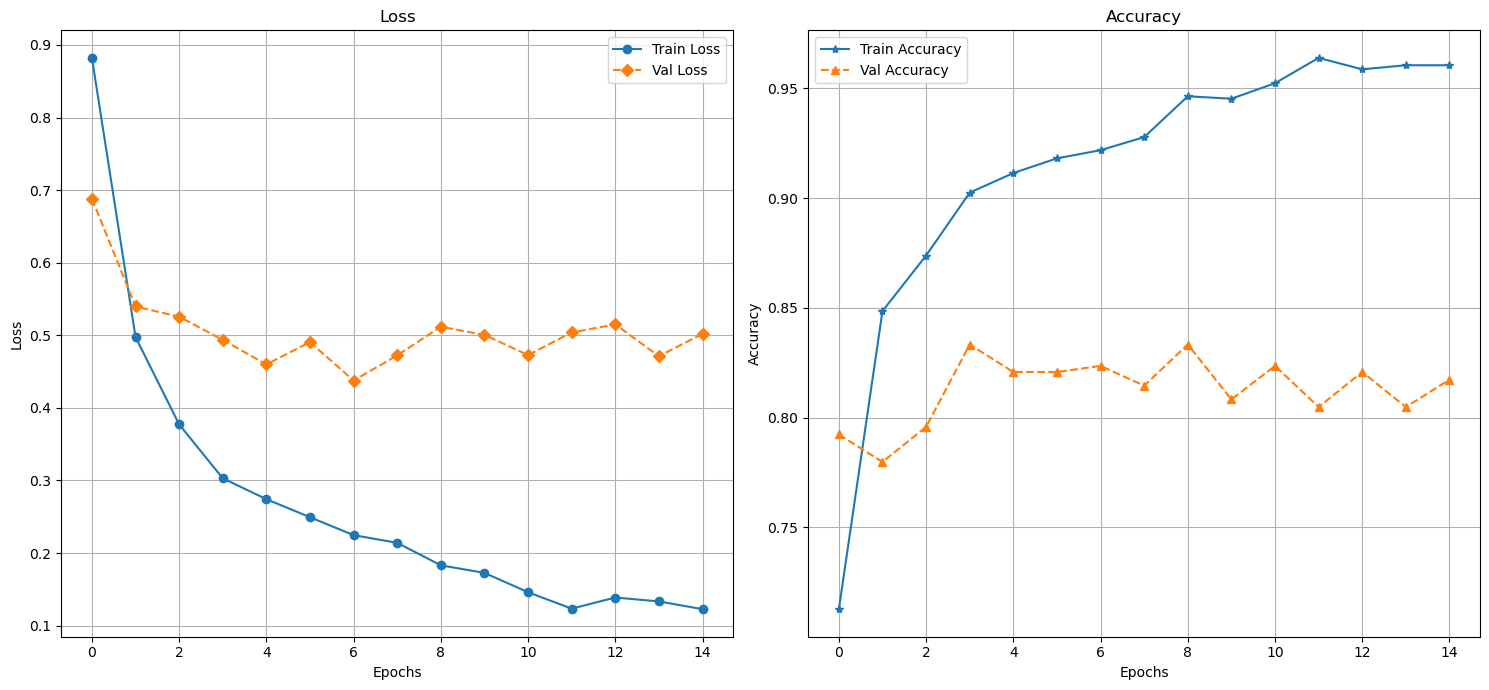

In [38]:
plot_loss_curves(results=results_se)

### Plotting the confusion matrix

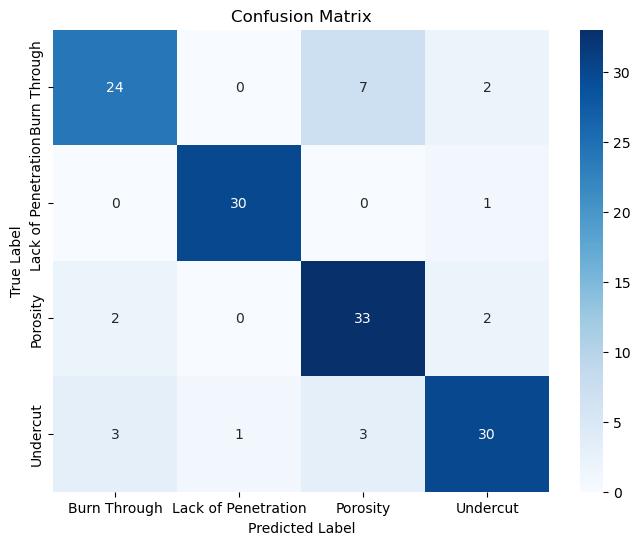

In [39]:
plot_confusion_matrix(model=effnetb2_se,
                     dataloader=test_dataloader,
                     class_names=class_names,
                     device=device)